In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy
import pandas as pd
from sklearn import cluster, metrics
from sklearn.manifold import MDS
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from tslearn.metrics import cdist_dtw, dtw

from numpy.random import default_rng
rng = default_rng(8888)

Generate data from $\mathbf{X}_t=\varepsilon_t$, where $\varepsilon_t\sim \mathcal{N}(\mu,\Sigma)$. Assume normalised. 

The original data has positive covariance between .19 and .76 after normalisation, so $\Sigma = \mathbf{a}^\mathrm{T}\mathbf{a}$ where $\mathbf{a}=[1, c]$ with $c\sim\mathcal{U}_{[0.15, 0.8]}$.

Q: apply autocorrelation as a convolution filter to data? (or add periodicity?)  
Q: this has been generated assuming that it's already scaled. How to add a perturbation so that it's also appropriately scaled (similar to original data)?

In [2]:
def generate_data(n_patients=10, 
                  pct_abnormal=0.2, 
                  perturb_method=['gaussian', 'gradual rise', 'log', 'opposite'], 
                  verbose=False):
    """
    pct_abnormal: percentage of patients for which to add a perturbation, float between 0 and 1
    perturb_method: ['top hat', 'gaussian', 'gradual rise', 'log', 'opposite']
        constant: adds a flat value to existing series, basically increasing the means by amount
            set in perturb_constant
        gaussian: adds gaussian noise with a positive mean, set in perturb_mean
    """
    
    dfs_raw = []
    patient_list = list(range(1, n_patients+1)) #start at patient no. 1

    time_range = pd.date_range(start='1/1/2021', end='1/9/2021', freq='min') #starts and stops at midnight - this is 8 days
    
    for idx, df in enumerate(range(n_patients)):
        df = pd.DataFrame(time_range, columns=['Timestamp'])
        labels = np.zeros(time_range.shape[0])

        # generate mean, covariance matrices 
        # going to normalize them later anyway, so precise values don't matter
        mean = np.array([0,0])
        cov_r = rng.uniform(low=0.15, high=0.6, size=1)[0]
        cov = np.array([[1., cov_r],[cov_r, 1.]])
        vitals = rng.multivariate_normal(mean, cov, time_range.shape[0])
        
        # add some sinusoidal variation (an abomination of a function, see graph below)
        freq = 1/(24*60) # 1 day, Hz*60 (minutes)
        ph = rng.integers(0, 60*12) # also in minutes, up to 12h lag
        amp = 0.25 # in std. devs 
        rhythm = np.fromfunction(lambda i, j: \
            -0.3*j*(amp*np.sin(2*np.pi*freq*i + ph)+0.15*np.sin(2*np.pi/240*i+10)) + \
            amp*(np.sin(2*np.pi*freq*i + ph)+0.05*np.sin(2*np.pi/240*i)), \
            vitals.shape, dtype=float)     
        vitals += rhythm
        
        # add some nonstationary elements? let's try some top hat functions
        # always add at the end of the time series to make my life easier, say the last 10% 
        # (approx 21.5 hours if using 9 days e.g. start='1/1/2021', end='1/8/2021')     
        # series of top hats with gaussian noise
        if 'gaussian' in perturb_method:
            if idx+1 > n_patients*pct_abnormal and idx+1 <= n_patients*pct_abnormal*2:
                cov_r = rng.uniform(low=0.25, high=0.5, size=(1,2)) # increase variance a bit
                cov = cov_r.T*cov_r
                perturb_mean=[1.5, 0] # 1.5 std devs on ONE variable (can change this...)
                perturb = rng.multivariate_normal(perturb_mean, cov, time_range.shape[0])
                perturb_idx = int(time_range.shape[0]*0.9) # change vals AFTER this
                perturb[:perturb_idx] = 0
                vitals += perturb
                labels[perturb_idx+1:] = 1
                
                if verbose:
                    print(f"perturbed (gaussian). Label 1")
            
        if 'top hat' in perturb_method and 'gaussian' not in perturb_method:
            # use either this or gaussian, not both
            if idx+1 > n_patients*pct_abnormal and idx+1 <= n_patients*pct_abnormal*2:
                var = rng.uniform(low=0.5, high=1.5, size=1) # increase variance a bit
                perturb_var = rng.normal(0, var, time_range.shape[0]) # add some variance to both
                t = np.arange(time_range.shape[0])
                perturb_mean = np.where(t%600 <=120, 1.5, 0) # bunch of little top hats
                
                perturb_idx = int(time_range.shape[0]*0.9) # change vals AFTER this
                perturb[:perturb_idx] = 0
                vitals[:,0] += perturb_mean # NOTE: changed here to only change ONE vital sign
                vitals[:,0] += perturb_var
                labels[perturb_idx+1:] = 1
                
                if verbose:
                    print(f"perturbed (top hat). Label 1")
                
        # increase over the period of a day
        if 'gradual rise' in perturb_method:
            if idx+1 > n_patients*pct_abnormal*2 and idx+1 <= n_patients*pct_abnormal*3:
                # linear increase in 2D, from 24 hours before end of recording
                perturb_idx = int(24*60) # 24 hours of indices - take LAST 
                perturb = np.zeros_like(vitals)
                # 2 standard deviations - big increase!
                perturb[-perturb_idx:] = np.fromfunction(lambda i, j: i, (perturb_idx, 2), dtype=float)*(1.5/perturb_idx) 
                vitals += perturb
                # how early should we be able to detect this? There should be a trend, so instantly
                labels[-perturb_idx+1:] = 2
                
                if verbose:
                    print(f"perturbed (gradual rise). Label 2")
        
        # increase quickly and stay high
        if 'log' in perturb_method:
            if idx+1 > n_patients*pct_abnormal*3 and idx+1 <= n_patients*pct_abnormal*4:
                perturb = np.zeros_like(vitals)
                perturb_idx = int(time_range.shape[0]*0.1) # take from end to this idx, so -ve
                perturb[-perturb_idx:] = np.fromfunction(lambda i, j: np.log(i+1), (perturb_idx, 2), dtype=float)*(1/7)
                vitals += perturb
                labels[-perturb_idx+1:] = 3
                
                if verbose:
                    print(f"perturbed (logarithmic increase). Label 3")
            
        # vitals go in opposite directions
        if 'opposite' in perturb_method:
            if idx+1 > n_patients*pct_abnormal*4 and idx+1 <= n_patients*pct_abnormal*5:
                perturb = np.zeros_like(vitals)
                perturb_idx = int(time_range.shape[0]*0.1)
                perturb[-perturb_idx:] =  np.fromfunction(lambda i, j: j*2*np.log(i+1)-np.log(i+1), \
                                                          (perturb_idx, 2), dtype=float)*(1/7)
                vitals += perturb
                labels[-perturb_idx+1:] = 4
                
                if verbose:
                    print(f"perturbed (opposite directions). Label 4")
        
        if verbose:
            print(f"mean {np.mean(vitals)}")
            print(f"var {np.var(vitals)}\n")

        df['Lifetouch Heart Rate'] = vitals[:,0]
        df['Lifetouch Respiration Rate'] = vitals[:,1]
        df['Labels'] = labels
        dfs_raw.append(df)
        
    return dfs_raw, patient_list

## Smooth, split, cluster

In [3]:
def preprocessing(dfs_raw, length=180, window=25):
    # length parameter: 3 hours or 180 minutes
    # normalize then apply rolling window
    use_center=False
    smoothed_dfs = []
    labels = []

    # places in rightmost position in window, alternately can set center=True
    for df in dfs_raw:
        data = df[["Lifetouch Heart Rate", "Lifetouch Respiration Rate"]]
        ndf = (data - data.mean(skipna=True))/data.std(skipna=True)
        smoothed_dfs.append(ndf.rolling(window=window, center=use_center).median())
        labels.append(df["Labels"])
    
    return smoothed_dfs, labels


# length parameter is length of interval in minutes
def split_into_intervals(smoothed_dfs, labels, patient_list, length=180):
    data = []
    metadata = []
    source_file_list = []
    targets = []
    
    for idx, df in enumerate(smoothed_dfs):
        # initialize list into which we'll put the split arrays
        segments = [] 
        # and maybe a good idea to return the file index, start and stop indices
        metadata_pts = []
        source_list = []
        seg_labels = []

        # Find rows with any NaN values, create as mask
        # add leading and trailing buffer so we can compare to the next row sequentially
        mask = np.concatenate(( [True], df.isna().any(axis=1).to_numpy(), [True] ))

        # get start and stop limits, reshape them into array of (start, stop) pairs
        ss = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1,2)
        # mask to get contiguous data only greater in length than length parameter
        ss = ss[(ss[:,1] - ss[:,0]) > length]
        # find how many len(length) segments are in each contiguous block of data
        nb_splits = (ss[:,1] - ss[:,0])//length

        # finally, we can get our start, stop, nb_splits tuples and use np.split to
        # return a list of equal size arrays of our desired length
        ends = ss[:,1]
        starts = ends - nb_splits*length
        for start, end, nb_splits in zip(starts,ends,nb_splits):
            # Difference between append and extend here is how they're added to the 
            # list. Extend "flattens" the resulting list so we don't end up with extra
            # dimentions, but also we can't easily tell which original file the data 
            # belonged to, which is why I've included metadata. 
            segments.extend( np.split(df.to_numpy()[start:end],nb_splits) )
            seg_label = np.split(labels[idx].to_numpy()[start:end],nb_splits)
            for split in range(nb_splits):
                metadata_pts.append( ("Patient " + str(patient_list[idx]), start+split*length, start+(split+1)*length) )
                source_list.append(patient_list[idx])
                # find the modal label for this segment
                seg_labels.extend(scipy.stats.mode(seg_label[split])[0])
        
        if metadata_pts != []: # if no contiguous samples long enough, both lists are empty
            data.extend(segments)
            metadata.extend(metadata_pts)
            source_file_list.extend(source_list)
            targets.extend(seg_labels)
    
    return data, metadata, source_file_list, targets


def dtw_calc(data):    
    # take all the processed data, flatten each array, and add to a numpy array 
    # (n_epochs, epoch_length, n_variables)
    X_ts = np.empty((len(data), len(data[0]), smoothed_dfs[0].shape[1]))
    for i, seg in enumerate(data):
        X_ts[i] = seg
    # get the dtw distance matrix
    dtw_dist_matrix = cdist_dtw(X_ts)

    # Silhouette score
#     score = metrics.silhouette_score(dtw_dist_matrix, targets, metric="precomputed")
    
    return dtw_dist_matrix


def cluster_data(dtw_dist_matrix, targets):
    #hierarchical clustering using DTW distance matrix
    hierarchical_dtw = hierarchy.linkage(squareform(dtw_dist_matrix), method="average")

    # Silhouette score
    score = metrics.silhouette_score(dtw_dist_matrix, targets, metric="precomputed")

    return hierarchical_dtw, score

In [4]:
dfs_raw, patient_list = generate_data(n_patients=20, 
                  pct_abnormal=0.1, 
                  perturb_method=['gaussian', 'log', 'opposite'], 
                  verbose=True)

smoothed_dfs, labels = preprocessing(dfs_raw)

data, metadata, source_file_list, targets = \
    split_into_intervals(smoothed_dfs, labels, length=180, patient_list=patient_list)

mean 0.006587367682026591
var 1.0384080024827171

mean 0.012619650979548327
var 1.0242033579931051

perturbed (gaussian). Label 1
mean 0.08162930026319287
var 1.1433657151279495

perturbed (gaussian). Label 1
mean 0.0836485286069894
var 1.1514125286360999

mean -5.8272299070410456e-06
var 1.013437679858378

mean 0.013341038603687952
var 1.0143052275700493

perturbed (logarithmic increase). Label 3
mean 0.08181748426393173
var 1.1073424849239284

perturbed (logarithmic increase). Label 3
mean 0.0910693809113253
var 1.1043226299619238

perturbed (opposite directions). Label 4
mean 0.00027887151479162034
var 1.09201911026754

perturbed (opposite directions). Label 4
mean 0.007747245778259306
var 1.1255751445894222

mean 0.009877509101456343
var 1.0152283352768943

mean -0.0022577622096471373
var 1.0260373114140022

mean -0.005325050889790382
var 1.028956523871008

mean -0.005674004538279446
var 1.0191451739329591

mean 0.004760524271589522
var 1.0306214462184553

mean -0.00826676860000007

In [5]:
# time_range = pd.date_range(start='1/1/2021', end='1/9/2021', freq='min')
# mean = np.array([0,0])
# cov_r = rng.uniform(low=0.15, high=0.6, size=1)[0]
# cov = np.array([[1., cov_r],[cov_r, 1.]])
# vitals = rng.multivariate_normal(mean, cov, time_range.shape[0])

# cov_r = rng.uniform(low=0.25, high=0.5, size=(1,2)) # increase variance a bit
# cov = cov_r.T*cov_r
# perturb_mean=[1.5, 1] # 1.5 std devs (can change this...)
# perturb = rng.multivariate_normal(perturb_mean, cov, time_range.shape[0])
# perturb_idx = int(time_range.shape[0]*0.9) # change vals AFTER this
# perturb[:perturb_idx] = 0
# perturb[:,0]

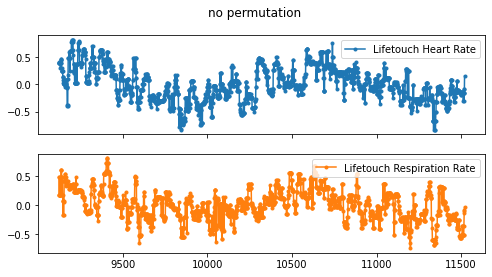

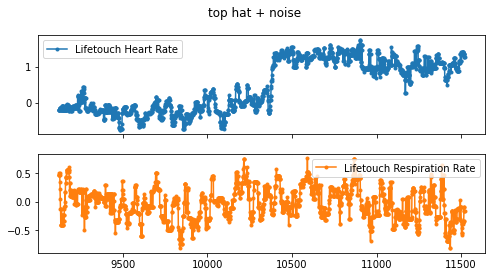

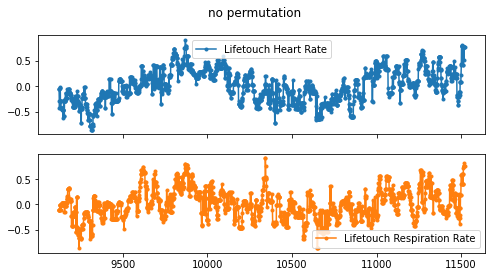

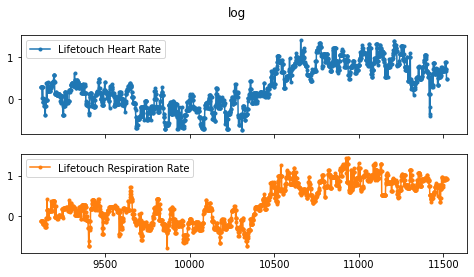

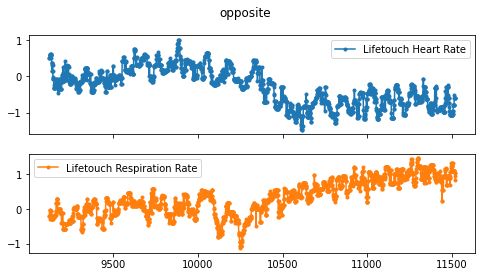

In [6]:
types = ['no permutation', 'top hat + noise', 'no permutation', 'log', 'opposite']

n = 2 # n_patients*pct_abnormal

for i in range(5):
#     label = int(scipy.stats.mode(labels[i*n][-1100:], keepdims=True)[0][0])
    label = int(scipy.stats.mode(labels[i*n][-1100:])[0][0])
#     print(label)
    smoothed_dfs[i*n].iloc[-2400:].plot(subplots=True, style='.-', figsize=(8,4), title=types[label])

`hierarchical_dtw`:  A $(n-1)$ by 4 matrix `z` is returned. At the $i$-th iteration, clusters with indices `Z[i, 0]` and `Z[i, 1]` are combined to form cluster $n+i$. A cluster with an index less than $n$ corresponds to one of the $n$ original observations. The distance between clusters `Z[i, 0]` and `Z[i, 1]` is given by `Z[i, 2]`. The fourth value `Z[i, 3]` represents the number of original observations in the newly formed cluster.

In [7]:
time_range = pd.date_range(start='1/1/2021', end='1/9/2021', freq='min')
len(time_range)/180


64.00555555555556

In [8]:
# this is the time consuming bit
dtw_dist_matrix = dtw_calc(data)

In [9]:
# MDS embedding 
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=326)
X_dtw_transformed = embedding.fit_transform(dtw_dist_matrix)

In [10]:
pat_number = 1

sfl = np.asarray(source_file_list)
pat_mask = np.where(sfl==pat_number)
X_dtw_transformed

array([[ 2.75422745,  2.11669213],
       [ 2.56503427,  0.20333513],
       [ 2.69010313, -3.7926146 ],
       ...,
       [ 0.23521306, -0.27322742],
       [ 4.3490534 ,  2.80801532],
       [-0.54212986, -3.5354982 ]])

In [11]:
hierarchical_dtw = hierarchy.linkage(squareform(dtw_dist_matrix), method="average")

# Silhouette score
# want predicted membership, not targets
# score = metrics.silhouette_score(dtw_dist_matrix, targets, metric="precomputed")

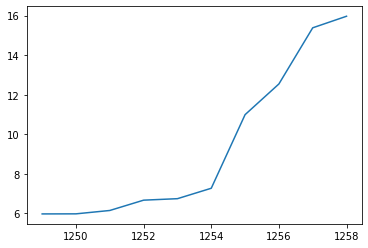

In [12]:
xs = np.arange(hierarchical_dtw[:,2].shape[0])
fig, ax = plt.subplots()
ax.plot(xs[-10:], hierarchical_dtw[:,2][-10:])


plt.show()

In [13]:
0.6*max(hierarchical_dtw[:,2])

9.581534605073193

In [14]:
"""
t : scalar
    For criteria ‘inconsistent’, ‘distance’ or ‘monocrit’,
        this is the threshold to apply when forming flat clusters.
    For ‘maxclust’ or ‘maxclust_monocrit’ criteria,
        this would be max number of clusters requested.
citerion: str
    distance :
        Forms flat clusters so that the original observations in 
        each flat cluster have no greater a cophenetic distance than t.

        The cophenetic distance between two objects is the height 
        of the dendrogram where the two branches that include the 
        two objects merge into a single branch.
"""
# this should be the same for colors on dendrograms below as well as 
# flat cluster membership.
thresh=10 # 0.6*max(hierarchical_dtw[:,2])

y_pred = hierarchy.fcluster(hierarchical_dtw, thresh, criterion='distance')
y_pred -= np.ones_like(y_pred) # because y_pred starts at 1 for some reason

In [15]:
# Silhouette score
# want predicted membership, not targets
score = metrics.silhouette_score(dtw_dist_matrix, y_pred, metric="precomputed")
score

0.5066523836436703

In [16]:
print(np.unique(y_pred))
print(len(y_pred))
print(len(targets))

[0 1 2 3 4]
1260
1260


**CAREFUL!** `y_pred` is not the same indices as `targets`! y_pred assigns arbitrary labels!

In [17]:
mdata1 = np.asarray(metadata)[np.where(y_pred==1)[0]]
targs = np.asarray(targets)[np.where(y_pred==1)[0]].reshape((-1,1))
mdata1 = np.hstack((mdata1, targs))
mdata1

array([['Patient 7', '10441', '10621', '3.0'],
       ['Patient 7', '10621', '10801', '3.0'],
       ['Patient 7', '10801', '10981', '3.0'],
       ['Patient 7', '10981', '11161', '3.0'],
       ['Patient 7', '11161', '11341', '3.0'],
       ['Patient 7', '11341', '11521', '3.0'],
       ['Patient 8', '10441', '10621', '3.0'],
       ['Patient 8', '10621', '10801', '3.0'],
       ['Patient 8', '10801', '10981', '3.0'],
       ['Patient 8', '10981', '11161', '3.0'],
       ['Patient 8', '11161', '11341', '3.0'],
       ['Patient 8', '11341', '11521', '3.0']], dtype='<U32')

##  DTW distance matrix and clustering

In [18]:
# approx how many epochs should be outliers?
# n_timesteps per patient/epoch size * n_patients * pct_abnormal * pct_perturbed
dfs_raw[0].shape[0]/180*10*0.4*0.1

25.60222222222223

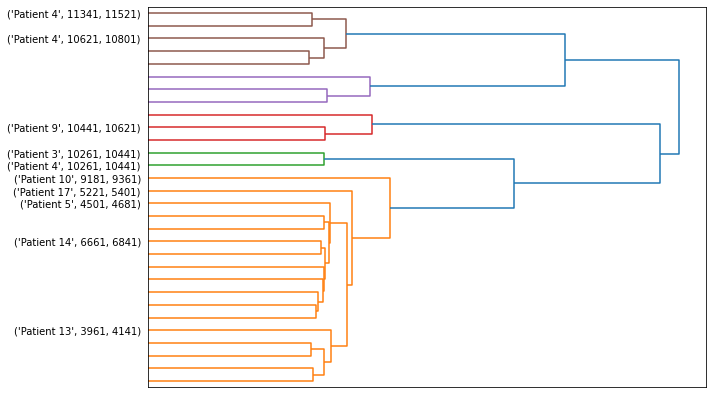

In [19]:
plt.figure(figsize=(10, 7))
hierarchy.dendrogram(
    hierarchical_dtw,
    orientation='right',
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,
    labels=metadata,
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_rotation=0.,
    color_threshold=thresh,
    )
# plt.title("Trucated dendrogram of epoch clusters\n using DTW distance measure")
plt.xticks([])
plt.rcParams.update({'font.size': 15, "axes.facecolor": (1.0, 1.0, 1.0, 0.0), 'text.color': 'k', 
                     'axes.labelcolor' : 'k'})
# plt.savefig('figures/al-dendrogram', format='pdf', bbox_inches='tight')
plt.show()

In [20]:
def plot_single_trajectory(labels=source_file_list, 
                           metric='euclidean', 
                           color_file=1, 
                           seed=0, # actually not used
                           ax=None,
                          ): 
    """    
    metric: str, default='euclidean'
        The distance matrix to use for the embedding, can be euclidean or dtw
        
    labels: 1D array or list of len(embedding.shape[0])
        The labels corresponding to the files in the embedding
    
    color_file: int, default=1
        index of the file to appear in red; all others will be grey
        
    """

    sfl_greyscale = [1 if i==color_file+1 else 0 for i in labels] # +1 because I can't count
    sfl_greyscale = np.asarray(sfl_greyscale)
    
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['grey', 'blue'])

    # hackery to get the index of the last 1 value in the array (and first)
    start = sfl_greyscale.argmax()
    end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()
    
    if metric=='euclidean':
        X_embed = X_transformed
        title = f'MDS embedding using Euclidean distance matrix'
    elif metric=='dtw':
        X_embed = X_dtw_transformed
        title = f'MDS embedding using DTW distance matrix'
    else:
        print('Distance metric not recognized.')
        return
        
    
    # plot the things
    plt.figure(figsize=(6.5, 4.5))
    plt.scatter(X_embed[:,0], X_embed[:,1],
               c=sfl_greyscale,
               cmap=cmap)

    if sfl_greyscale.max() == 1:
        plt.plot(X_embed[start:end,0], X_embed[start:end,1],  '.b-', 
                 label=f"Generated file {color_file}")

        plt.annotate(f"Start", 
                     (X_embed[start,0], X_embed[start,1]),
                     xytext=(1,5),
                     textcoords="offset points",
                    )
        plt.annotate(f"End", 
                     (X_embed[end-1,0], X_embed[end-1,1]), #end-1 for correct indexing
                     xytext=(5,0),
                     textcoords="offset points",
                    )
    plt.xticks([])
    plt.yticks([])
    plt.legend(loc="upper right")
    plt.title('D', y=0.95, x=0.05, pad=-10)
#     plt.title(title)
    plt.tight_layout()
#     plt.savefig(f'figures/mds-pt{color_file}', format='pdf')
    plt.show()

Text(0.5, 1.0, 'MDS embedding using DTW distance matrix')

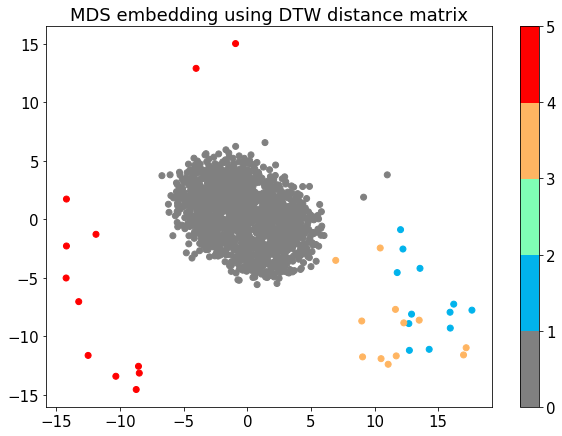

In [21]:
plt.figure(figsize=(10, 7))

cmap = plt.cm.rainbow
# extract all colors from the map 
# from https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
# create the new map
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
n_clust = int(np.max(targets)+1)
bounds = np.linspace(0, n_clust, n_clust+1)
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=targets,
           cmap=cmap, norm=norm)
plt.colorbar()
plt.title('MDS embedding using DTW distance matrix')

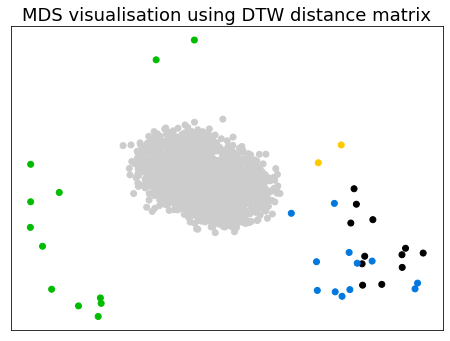

In [52]:
plt.figure(figsize=(6.5, 5))
cmap = plt.cm.nipy_spectral
# # extract all colors from the map 
# # from https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # force the first color entry to be grey
# cmaplist[0] = (.5, .5, .5, 1.0)
# # create the new map
# cmap = colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)
# # define the bins and normalize
# n_clust = int(np.max(y_pred)+1)
# bounds = np.linspace(0, n_clust, n_clust+1)
# norm = colors.BoundaryNorm(bounds, cmap.N)

plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=y_pred,
#            marker=targets,
           cmap=cmap)
# plt.colorbar()
plt.title('MDS visualisation using DTW distance matrix')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
# plt.title('C', y=0.95, x=0.05, pad=-10)

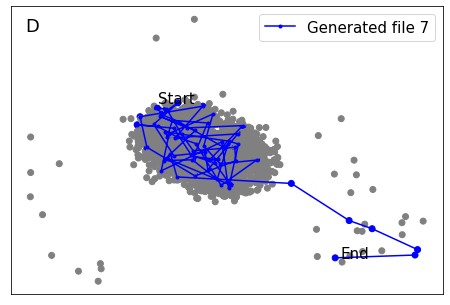

In [23]:
plt.rcParams.update({'font.size': 15, "axes.facecolor": (1.0, 1.0, 1.0, 0.0), 'text.color': 'k'}) # last entry is transparency
plot_single_trajectory(metric='dtw', color_file=7)


In [24]:
# print(targets[500:1000])

In [25]:
# print(y_pred[500:1000])

In [26]:
np.unique(y_pred)

array([0, 1, 2, 3, 4], dtype=int32)

In [27]:
targets = np.array(targets)
mask0 = np.where(targets==0)
print("central cluster")
print(np.where(y_pred[mask0]==4, 1, 0).mean())
print(np.where(y_pred[mask0]!=4, 1, 0).sum())

mask1 = np.where(targets==1)
print("step")
print(np.where(y_pred[mask1]==0, 1, 0).mean())

mask2 = np.where(targets==3)
print("log")
print(np.where(y_pred[mask2]==1, 1, 0).mean())
print(np.where(y_pred[mask2]==1, 1, 0).sum())
# print(np.where(y_pred[mask3]==0, 1, 0).mean())

mask3 = np.where(targets==4)
print("inverted")
print(np.where(y_pred[mask3]==2, 1, 0).mean())
# print(np.where(y_pred[mask2]==2, 1, 0).mean())

central cluster
0.9983660130718954
2
step
1.0
log
1.0
12
inverted
1.0


In [28]:
time_range = pd.date_range(start='1/1/2021', end='1/9/2021', freq='min')
len(time_range)/180*7

448.0388888888889

In [29]:
len(mask2[0])*.75

9.0

The Silhouette Coefficient for a point $i$ is defined as
$$S(i) = \frac{b(i)-a(i)}{\max\{a(i), b(i)\}}$$
where $b(i)$ is the smallest average distance of point $i$ to all points in any other cluster and $a(i)$ is the average distance of $i$ from all other points in its cluster ([Source](https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad)). Since this is agglomerative clustering, $b(i)$ is trivial, but $a(i)$ would have to be computed manually? Need to have a think about this.

In [30]:
# from tslearn.clustering import TimeSeriesKMeans

In [31]:
# X_ts = np.empty((len(data), len(data[0]), smoothed_dfs[0].shape[1]))
# for i, seg in enumerate(data):
#     X_ts[i] = seg
# print(X_ts.shape)

# n_clust = int(np.max(targets)+1)

# dba_km = TimeSeriesKMeans(n_clusters=n_clust,
#                           n_init=2,
#                           metric="dtw",
#                           verbose=True,
#                           max_iter_barycenter=10,
#                           random_state=8888)
# y_pred = dba_km.fit_predict(X_ts)

In [32]:
# n_clust

In [33]:
# for yi in range(n_clust):
#     plt.figure(figsize=(10, 7))
#     plt.subplot(3, 2, yi+1)
#     for xx in X_ts[y_pred == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
#     plt.xlim(0, 180) #epoch length
#     plt.ylim(-2, 2)
#     plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#              transform=plt.gca().transAxes)
#     if yi == 1:
#         plt.title("DBA $k$-means")

In [34]:
score = metrics.silhouette_score(dtw_dist_matrix, y_pred, metric="precomputed")
score

0.5066523836436703

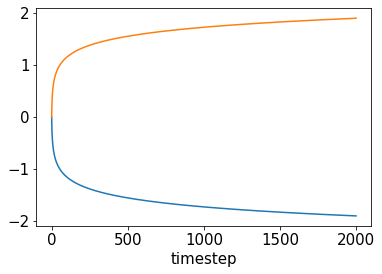

In [35]:
t = np.arange(0, 2000, 1)
# a = np.fromfunction(lambda i, j: np.log(i+1), (perturb_idx, 2), dtype=float)*(1/3)
a = np.fromfunction(lambda i, j: j*2*np.log(i+1)-np.log(i+1), (2000, 2), dtype=float)*(1/4)

fig, ax = plt.subplots()
# ax.plot(t, perturb[-2000:])
ax.plot(t, a)

ax.set(xlabel='timestep')

plt.show()

In [36]:
1/(60*4)


0.004166666666666667

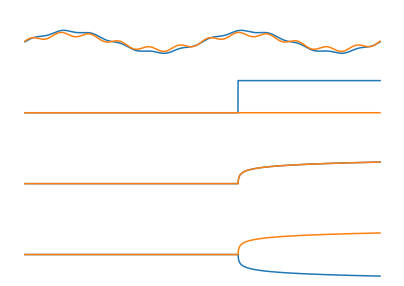

In [37]:
t_idx = 2880 # exactly 2 days
time_range = pd.date_range(start='1/1/2021', end='1/9/2021', freq='min')
perturb_idx = int(time_range.shape[0]*0.1) # take from end to this idx, so -ve

t = np.arange(0, t_idx, 1) 
# a = np.fromfunction(lambda i, j: np.log(i+1), (perturb_idx, 2), dtype=float)*(1/3)
freq = 1/(24*60) # 1 day, Hz*60 (minutes)
ph = 0 #rng.integers(0, 60*12) # also in minutes, up to 12h lag
a = np.fromfunction(lambda i, j: -0.3*j*(0.5*np.sin(2*np.pi*freq*i + ph)+
                                         0.2*np.sin(2*np.pi/240*i+10)) + 
                    0.5*(np.sin(2*np.pi*freq*i + ph)+0.1*np.sin(2*np.pi/240*i)), 
                    (t_idx, 2), dtype=float)

fig, axs = plt.subplots(4, 1, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(7)
# ax.plot(t, perturb[-2000:])
axs[0].plot(t, a)
# axs[0].set(xlabel='timestep')

# cov_r = rng.uniform(low=0.25, high=0.5, size=(1,2)) # increase variance a bit
# cov = cov_r.T*cov_r
cov = np.zeros((2,2))
perturb_mean=[1.5, 0] # 1.5 std devs on ONE variable (can change this...)
b = rng.multivariate_normal(perturb_mean, cov, time_range.shape[0])
b[:-perturb_idx] = 0
# b[-t_idx:]+=a
axs[1].plot(t, b[-t_idx:])

c = np.zeros((time_range.shape[0], 2))
c[-perturb_idx:] = np.fromfunction(lambda i, j: np.log(i+1), (perturb_idx, 2), 
                                   dtype=float)*(1/7)
# c[-t_idx:]+=a
axs[2].plot(t, c[-t_idx:])

d = np.zeros((time_range.shape[0], 2))
d[-perturb_idx:] = np.fromfunction(lambda i, j: j*2*np.log(i+1)-np.log(i+1), \
                                        (perturb_idx, 2), dtype=float)*(1/7)
# d[-t_idx:]+=a
axs[3].plot(t, d[-t_idx:])
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
plt.savefig(f'figures/perturbs', format='pdf', bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

In [38]:
int(time_range.shape[0]*0.1)/180

6.4

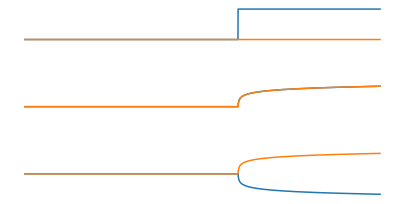

In [39]:
t_idx = 2880 # exactly 2 days
time_range = pd.date_range(start='1/1/2021', end='1/9/2021', freq='min')
perturb_idx = int(time_range.shape[0]*0.1) # take from end to this idx, so -ve

t = np.arange(0, t_idx, 1) 
# a = np.fromfunction(lambda i, j: np.log(i+1), (perturb_idx, 2), dtype=float)*(1/3)
freq = 1/(24*60) # 1 day, Hz*60 (minutes)
ph = 0 #rng.integers(0, 60*12) # also in minutes, up to 12h lag
a = np.fromfunction(lambda i, j: -0.3*j*(0.5*np.sin(2*np.pi*freq*i + ph)+
                                         0.2*np.sin(2*np.pi/240*i+10)) + 
                    0.5*(np.sin(2*np.pi*freq*i + ph)+0.1*np.sin(2*np.pi/240*i)), 
                    (t_idx, 2), dtype=float)

fig, axs = plt.subplots(3, 1, sharey=True)
fig.set_figheight(3.5)
fig.set_figwidth(7)
# ax.plot(t, perturb[-2000:])
# axs[0].plot(t, a)
# axs[0].set(xlabel='timestep')

# cov_r = rng.uniform(low=0.25, high=0.5, size=(1,2)) # increase variance a bit
# cov = cov_r.T*cov_r
cov = np.zeros((2,2))
perturb_mean=[1.5, 0] # 1.5 std devs on ONE variable (can change this...)
b = rng.multivariate_normal(perturb_mean, cov, time_range.shape[0])
b[:-perturb_idx] = 0
# b[-t_idx:]+=a
axs[0].plot(t, b[-t_idx:])

c = np.zeros((time_range.shape[0], 2))
c[-perturb_idx:] = np.fromfunction(lambda i, j: np.log(i+1), (perturb_idx, 2), 
                                   dtype=float)*(1/7)
# c[-t_idx:]+=a
axs[1].plot(t, c[-t_idx:])

d = np.zeros((time_range.shape[0], 2))
d[-perturb_idx:] = np.fromfunction(lambda i, j: j*2*np.log(i+1)-np.log(i+1), \
                                        (perturb_idx, 2), dtype=float)*(1/7)
# d[-t_idx:]+=a
axs[2].plot(t, d[-t_idx:])
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
plt.savefig(f'figures/perturbs-only', format='pdf', bbox_inches='tight', 
               transparent=True,
               pad_inches=0)
plt.show()

In [40]:
6*60


360

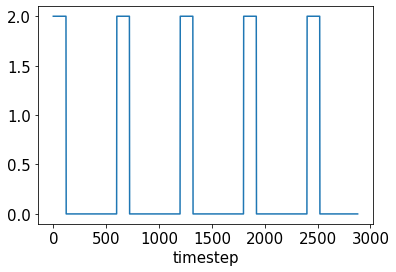

In [41]:
t = np.arange(0, 2880, 1) # exactly 2 days

a = np.where(t%600 <=120, 2, 0)

fig, ax = plt.subplots()
# ax.plot(t, perturb[-2000:])
ax.plot(t, a)

ax.set(xlabel='timestep')

plt.show()

In [42]:
dfs_raw

[                Timestamp  Lifetouch Heart Rate  Lifetouch Respiration Rate  \
 0     2021-01-01 00:00:00             -0.736969                   -0.573997   
 1     2021-01-01 00:01:00              0.660630                   -0.207843   
 2     2021-01-01 00:02:00             -1.993921                   -0.914951   
 3     2021-01-01 00:03:00             -0.531470                   -0.826859   
 4     2021-01-01 00:04:00             -1.534661                   -1.602769   
 ...                   ...                   ...                         ...   
 11516 2021-01-08 23:56:00             -1.349143                   -0.129212   
 11517 2021-01-08 23:57:00              0.833305                    2.389614   
 11518 2021-01-08 23:58:00              0.992835                    1.413838   
 11519 2021-01-08 23:59:00             -1.085970                    0.174431   
 11520 2021-01-09 00:00:00              0.645082                    0.102585   
 
        Labels  
 0         0.0  
 1  

In [43]:
a

array([2, 2, 2, ..., 0, 0, 0])

In [44]:
l = 5

# generate mean, covariance matrices (assume normalized)
mean = np.array([0,0])
cov_r = rng.uniform(low=0.15, high=0.8, size=1)[0]
cov = np.array([[1., cov_r],[cov_r, 1.]])
vitals = rng.multivariate_normal(mean, cov, 5)
print(vitals)

perturb = rng.multivariate_normal(mean, cov, l)
cutoff = int(l*0.8)
perturb[:cutoff] = 0
print(perturb)

vitals += perturb

print(vitals)

[[ 1.74448838  2.449803  ]
 [-0.17090371 -1.15151501]
 [ 0.81524853 -0.93187938]
 [ 0.1203901  -0.92232376]
 [-1.04078886 -1.65286375]]
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-1.23694165 -2.36202726]]
[[ 1.74448838  2.449803  ]
 [-0.17090371 -1.15151501]
 [ 0.81524853 -0.93187938]
 [ 0.1203901  -0.92232376]
 [-2.27773051 -4.01489101]]


In [45]:
l = 5
perturb_constant = [0.2, 0.1]

# generate mean, covariance matrices (assume normalized)
mean = np.array([0,0])
cov_r = rng.uniform(low=0.15, high=0.8, size=1)[0]
cov = np.array([[1., cov_r],[cov_r, 1.]])
vitals = rng.multivariate_normal(mean, cov, 5)
print(vitals)

perturb = np.ones_like(vitals)*perturb_constant
print(perturb)
perturb_idx = int(l*0.9) # values AFTER this index will be altered
perturb[:perturb_idx] = 0
vitals += perturb

print(vitals)

[[-0.24199296  0.87050251]
 [-1.3665058  -1.82977253]
 [-0.25370431 -1.16770847]
 [ 1.0190162   0.76351255]
 [-0.79426215 -1.6184054 ]]
[[0.2 0.1]
 [0.2 0.1]
 [0.2 0.1]
 [0.2 0.1]
 [0.2 0.1]]
[[-0.24199296  0.87050251]
 [-1.3665058  -1.82977253]
 [-0.25370431 -1.16770847]
 [ 1.0190162   0.76351255]
 [-0.59426215 -1.5184054 ]]


In [46]:
cov_r = rng.uniform(low=0.15, high=0.8, size=(1,2))
print(cov_r)
cov_r.T*cov_r

[[0.1773497  0.71932355]]


array([[0.03145291, 0.12757181],
       [0.12757181, 0.51742636]])

In [47]:
n_patients = 10
pct_abnormal = 0.2

for idx in range(n_patients):
    if idx+1 <= n_patients*pct_abnormal:
        print(idx)
    if idx+1 > n_patients*pct_abnormal and idx+1 <= n_patients*pct_abnormal*2:
        print(f"a {idx}")

0
1
a 2
a 3


In [48]:
# 60 patients. Will take a while to run.

# dfs_raw_60, patient_list = generate_data(n_patients=60, 
#                   pct_abnormal=0.1, 
#                   perturb_method=['gaussian', 'gradual rise', 'log', 'opposite'], 
#                   verbose=True)

# smoothed_dfs_60, labels_60 = preprocessing(dfs_raw)

# data_60, metadata_60, source_file_list_60, targets_60 = \
#     split_into_intervals(smoothed_dfs_60, labels_60, length=180, patient_list=patient_list)

# # this is the time consuming bit
# dtw_dist_matrix_60 = dtw_calc(data_60)

# hierarchical_dtw_60, score_60 = cluster_data(dtw_dist_matrix_60, targets_60)
# print(f"Score: {score_60}")

In [49]:
np.unique(y_pred).shape[0]

5

In [50]:
sscores = []
thresholds = np.arange(0.6, 1, 0.05)

for pct in thresholds:
    thresh=pct*max(hierarchical_dtw_60[:,2])

    y_pred_60 = hierarchy.fcluster(hierarchical_dtw_60, thresh, criterion='distance')

    # Silhouette score
    # want predicted membership, not targets
    score = metrics.silhouette_score(dtw_dist_matrix, y_pred_60, metric="precomputed")
    sscores.append(score)
    print(f"unique clusters: {np.unique(y_pred_60).shape[0]}, threshold: {pct:0.2f}, n score: {score:0.4f}")

NameError: name 'hierarchical_dtw_60' is not defined